In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [12]:
#the cmp of two-keys-sort
def by_dis(t):
    return t[0]

In [13]:
'''
    RET:
        dataset: the initial data (1024,1)
        label_true: the true label
'''

def LoadData( url, feas, labels ):
    
    _dataset = sio.loadmat( url )
    dataset = _dataset[feas]
    label_true = _dataset[labels]
    return dataset, label_true

In [14]:
'''
    RET:
        dis: the distance between vec_a and vec_b
'''

def CalcDist( vec_a, vec_b ):
    
    dis = np.sqrt( np.sum( (vec_a-vec_b)**2 ) )
    return dis

In [15]:
'''
    fisher for 2 datasets
    dataset_class: dictionary of dataset (key=label, val=dataset)
    u_class: dictionary of means (key=label, val=u)
'''

def LDA_2_AimD( dataset, label_true, aim_d ):
    
    n = len(dataset)
    #print("dataset shape:", dataset.shape)
    
    #get the label for classify
    label = []
    for i in label_true:
        label.append( i[0] )
    label = np.array( label )
    #print("label shape:", label.shape)
    label = list( set(label) )
    
    #merge the same_label samples, store them into a dictionary
    dataset_class = {}
    for i in label:
        nw_data = np.array( [ dataset[j] for j in range(n) if label_true[j] == i ] )
        dataset_class[i] = nw_data
    
    u = np.mean( dataset, axis = 0 )
    u_class = {}
    
    for i in label:
        u_class[i] = np.mean( dataset_class[i], axis = 0 )
    
    St = np.zeros( (len(u),len(u)) )
    St = np.dot( ( dataset - u ).T, (dataset - u) )
    #print("St shape:", St.shape)
    
    Sw = np.zeros( (len(u),len(u)) )
    for i in label:
        Sw += np.dot( (dataset_class[i]-u_class[i]).T, (dataset_class[i]-u_class[i]) )
    #print("Sw shape:", Sw.shape)
    
    Sb = np.zeros( (len(u),len(u)) )
    Sb = St - Sw
    #print("Sb shape:",Sb.shape)
    
    eig_vals, eig_vecs = np.linalg.eig( np.dot( np.linalg.pinv(Sw), Sb ) )

    sorted_indices = np.argsort( eig_vals )
    W = eig_vecs[ :, sorted_indices[:-aim_d-1:-1] ]
    
    feaset = []
    for i in range(n):
        feaset.append( np.dot(dataset[i], W) )
    return feaset, Sb, Sw, W, dataset_class, u_class
    

In [16]:
'''
    aim_d: the top aim_d featrue
    RET:
        feaset: the featrue for each sample after lda
'''

def GetFea( dataset, label_true, aim_d, model = 1 ):
    
    if model == 1:
        X = dataset
        y = np.array( [ i[0] for i in label_true ] )
        #lda
        '''
        lda = LinearDiscriminantAnalysis( n_components = aim_d )
        lda.fit( X, y )
        feaset = lda.transform( X )
        '''
        pca = PCA( n_components = aim_d )
        pca.fit( X )
        feaset = pca.fit_transform( X )
    elif model == 0:
        feaset, Sb, Sw, W, dataset_class, u_class = LDA_2_AimD( dataset, label_true, aim_d )

    return feaset

In [17]:
'''
    k = 7 means the k(17)nn
    The KNN function
    RET:
        
'''

def KNN( feaset, label_true, k = 7 ):
    
    n = len(feaset)
    label_pred = np.zeros(n)
    st_dis = []
    st_clu = []
    
    for i in range(n):
        
        i2each_dis = []
        
        for j in range(n):
            
            if i == j:
                continue
            nwdis = CalcDist( feaset[i], feaset[j] )
            i2each_dis.append( nwdis )
        
        i2each_dis = np.array( i2each_dis )
        i2each_dis_ind = np.argsort( i2each_dis )
        
        sm_dis = []
        sm_clu = []
        vote_result = {}

        for j in range(k):
            sm_dis.append( i2each_dis[ i2each_dis_ind[j] ])
            tp_label = label_true[ i2each_dis_ind[j] ]
            sm_clu.append( tp_label )
            vote_result[tp_label[0]] = vote_result.get( tp_label[0], 0 ) + 1
        
        st_dis.append( sm_dis )
        st_clu.append( sm_clu )
        label_pred[i] = max( vote_result, key=vote_result.get )
        
    return label_pred, st_dis, st_clu

In [18]:
def ARI( label_true, label_pred ):
    ratio = metrics.adjusted_rand_score( label_true.ravel(), label_pred.ravel() )
    return ratio

In [19]:
def Accuracy( _label_true, _label_pred ):
    fm = len(_label_true)
    fz = 0
    for i in range(len(_label_true)):
        if _label_true[i] == _label_pred[i]:
            fz += 1
    ratio = fz / fm
    return ratio

In [20]:
def main( url, feas, labels ):
    
    aim_d = 32
    dataset, label_true = LoadData( url, feas, labels )
    
    for mode in range(2):
        tp_y = []
        for aim_d in X_axis:
            feaset = GetFea( dataset, label_true, aim_d, 0 )
            label_pred, st_dis, st_clu = KNN( feaset, label_true )
            ratio = Accuracy( label_true, label_pred )
            tp_y.append(ratio)
        Y_axis[mode] = tp_y
        
    return dataset, label_true, label_pred, st_dis, st_clu

In [21]:
urls = [ 'data/COIL20.mat', 'data/Yale_32x32.mat' ]
feas = [ 'fea' ]
labels = [ 'gnd' ]

_data, _label = LoadData( urls[1], feas[0], labels[0] )
mxc = max( _label )[0]

Y_axis = {}
X_axis = [ i for i in range(1,mxc)]
print(X_axis)

dataset, label_true, label_pred, st_dis, st_clu = main( urls[1], feas[0], labels[0] )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [12]:
print(X_axis)
print(Y_axis[0])
print(Y_axis[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0.3515151515151515, 0.5818181818181818, 0.6545454545454545, 0.7878787878787878, 0.8606060606060606, 0.8727272727272727, 0.9212121212121213, 0.9333333333333333, 0.9454545454545454, 0.9575757575757575, 0.9575757575757575, 0.9575757575757575, 0.9575757575757575, 0.9575757575757575]
[0.16363636363636364, 0.24242424242424243, 0.3151515151515151, 0.4, 0.49696969696969695, 0.5515151515151515, 0.5272727272727272, 0.5454545454545454, 0.5575757575757576, 0.5818181818181818, 0.5575757575757576, 0.5696969696969697, 0.5818181818181818, 0.6181818181818182]


In [12]:
def Draw_result( X_axis, Y_axis ):
    plt.plot( Y_axis[0], c='red', label='LDA' )
    plt.plot( Y_axis[1], c='blue', label='PCA' )
    plt.xlabel('n-component for LDA/PCA')
    plt.xticks(range(-1,len(X_axis)+5))
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

The data/Yale_32x32.mat result.


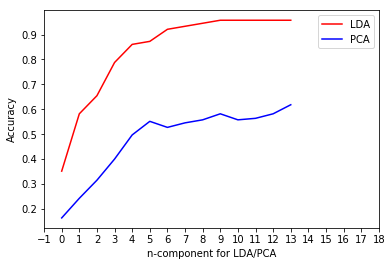

In [13]:
print("The {} result.".format( urls[1] ) )
Draw_result( X_axis, Y_axis )

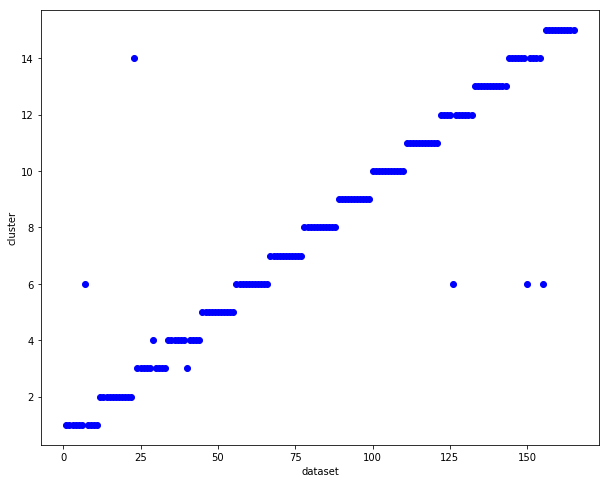

In [22]:
XX = [ i for i in range(1,len(_data)+1) ]
YY = label_pred

plt.scatter( XX, YY, c='b' )
plt.xlabel('dataset')
plt.ylabel('cluster')
plt.show()

In [11]:
nwct = 0
for i in range(lower_b, upper_b):
    pas = i - lower_b
    if label_true[i] != label_pred[i]:
        nwct += 1
    print(pas, label_true[pas], label_pred[pas])
print(nwct)

0 [1] 1.0
1 [1] 1.0
2 [1] 1.0
3 [1] 1.0
4 [1] 1.0
5 [1] 1.0
6 [1] 1.0
7 [1] 1.0
8 [1] 1.0
9 [1] 1.0
10 [1] 1.0
11 [1] 1.0
12 [1] 1.0
13 [1] 1.0
14 [1] 1.0
15 [1] 1.0
16 [1] 1.0
17 [1] 1.0
18 [1] 1.0
19 [1] 1.0
20 [1] 1.0
21 [1] 1.0
22 [1] 1.0
23 [1] 1.0
24 [1] 1.0
25 [1] 1.0
26 [1] 1.0
27 [1] 1.0
28 [1] 1.0
29 [1] 1.0
30 [1] 1.0
31 [1] 1.0
32 [1] 1.0
33 [1] 1.0
34 [1] 1.0
35 [1] 1.0
36 [1] 1.0
37 [1] 1.0
38 [1] 1.0
39 [1] 1.0
40 [1] 1.0
41 [1] 1.0
42 [1] 1.0
43 [1] 1.0
44 [1] 1.0
45 [1] 1.0
46 [1] 1.0
47 [1] 1.0
48 [1] 1.0
49 [1] 1.0
50 [1] 1.0
51 [1] 1.0
52 [1] 1.0
53 [1] 1.0
54 [1] 1.0
55 [1] 1.0
56 [1] 1.0
57 [1] 1.0
58 [1] 1.0
59 [1] 1.0
60 [1] 1.0
61 [1] 1.0
62 [1] 1.0
63 [1] 1.0
64 [1] 1.0
65 [1] 1.0
66 [1] 1.0
67 [1] 1.0
68 [1] 1.0
69 [1] 1.0
70 [1] 1.0
71 [1] 1.0
72 [2] 2.0
73 [2] 2.0
74 [2] 2.0
75 [2] 2.0
76 [2] 2.0
77 [2] 2.0
78 [2] 2.0
79 [2] 2.0
80 [2] 2.0
81 [2] 2.0
82 [2] 2.0
83 [2] 2.0
84 [2] 2.0
85 [2] 2.0
86 [2] 2.0
87 [2] 2.0
88 [2] 2.0
89 [2] 2.0
90 [2] 2.0
91 [2] 2.

In [5]:
_a = list(np.arange(1,10)) + list(np.arange(10,20,5))
print(_a)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
